In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
def prepare_profile_data(files):
    # prepare the data
    df = pd.DataFrame()
    spin_list = [] # a list for the spin_sum
    qsum_list = [] # a list for the quad_sum 
    cant_pos_list_x, cant_pos_list_y, cant_pos_list_z = [[] for  x in range(3)] # save the positions of the cantielever

    for i in tqdm(range(len(files))):
        spin = np.zeros(5000)
        spin_temp = files[i].spin_data
        for j in range(5000):
            spin[j]=np.average(spin_temp[10*j:10*j+9]) # average down to 5000 in order to match spin with the cantilever position.    
        spin_list.append(spin)
        qsum_list.append(files[i].quad_sum)
        cant_pos_list_x.append(files[i].cant_pos[0])
        cant_pos_list_y.append(files[i].cant_pos[1])
        cant_pos_list_z.append(files[i].cant_pos[2])
    df["QPD_SUM"] = qsum_list
    df["SPIN_SUM"] = spin_list 
    df["CANT_POS_X"] = cant_pos_list_x
    df["CANT_POS_Y"] = cant_pos_list_y
    df["CANT_POS_Z"] = cant_pos_list_z
    
    
    # use calibration
    ## applies calibration assuming x and y have the same
    df["CANT_POS_X_cal"] = df["CANT_POS_X"].apply(lambda element: voltage_to_x_position(element))  
    df["CANT_POS_Y_cal"] = df["CANT_POS_Y"].apply(lambda element: voltage_to_x_position(element)) 
    df["CANT_POS_Z_cal"] = df["CANT_POS_Z"].apply(lambda element: voltage_to_z_position(element))
    
    
    # differentiate the power to get dP/dx plots
    df["QPD_SUM_diff"] = df["QPD_SUM"].apply(lambda element: np.diff(element)) # 
    df["SPIN_SUM_diff"] = df["SPIN_SUM"].apply(lambda element: np.diff(element)) # negative to make Gaussian positive for x

    return df

In [19]:
# step 1 load the data for x and y

Year = "2020"
Month = "09"
Day = "03"
BeadNumber = 1
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/BeamProfile/"
fname_x="BeamProfileX2"
fname_y="BeamProfileY2"
files_x = load_dir(folder, file_prefix = fname_x, max_file=100)
files_y = load_dir(folder, file_prefix = fname_y, max_file=100)

  2%|▏         | 2/91 [00:00<00:04, 17.86it/s]

91  files in folder
91  files loaded


100%|██████████| 91/91 [00:04<00:00, 22.93it/s]

91  files in folder
91  files loaded


In [20]:
df_x = prepare_profile_data(files_x)
df_y = prepare_profile_data(files_y)

100%|██████████| 91/91 [00:02<00:00, 31.14it/s]


In [21]:
def fit_dP_dX(df,axis="Y",detector="SPIN",avg_rng=10,sub_sample=False,plot=False,logscale=True):
    lower_range = 2100
    upper_range= 2000
        # average and fit
    sigma_list,sigma_err_list,mean_list,chi2_list,fit_list = [[] for x in range(5)]
    if(sub_sample==True):length=10
    else: length=len(df)
    for j in tqdm(np.arange(0,length,1)):
        averaged_series = pd.Series(df["%s_SUM_diff" %detector][j]).ewm(span=avg_rng,adjust=True).mean()
        data_y = averaged_series[lower_range:-upper_range]/averaged_series.mean()#df["QPD_SUM_diff"][0][1300:-1400] # give y data 
        if(np.sum(data_y)<0): data_y = -data_y
        data_x = df["CANT_POS_%s_cal" %axis][0][lower_range:-upper_range-1] # give x data
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty

        def chisquare_gaussian(area,mean,sigma,constant):
            return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
        maxy = np.array(data_x)[np.argmax(np.array(data_y))]
        #print(maxy,np.sum(data_y))
        #plt.plot(data_y)
        m=Minuit(chisquare_gaussian, 
                 area = 5000, # set start parameter
                 limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
                 #fix_area = "False", # you can also fix it
                 mean = maxy,
                 #fix_mean = "True",
                 limit_mean = (maxy-20, maxy+20),
                 sigma = 1.9,
                 limit_sigma=(1,4),
                 #fix_sigma="True",
                 constant = 0,
                 fix_constant="True",
                 errordef = 1,
                 print_level=0,
                 pedantic=False)
        #print('Now proceed with the fit.')
        m.migrad()
        #print()
        m.minos()#, if you need fancy mapping
        chisquare=m.fval
        #print(chisquare)
        #print(m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"])
        if(plot==True):
            plt.plot(data_x,data_y)
            plt.plot(data_x,gaussian(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]))
            if(logscale==True):plt.yscale("log")
            plt.show()
    
        sigma_list.append(2*m.values["sigma"])
        sigma_err_list.append(2*m.errors["sigma"])
        mean_list.append(m.values["mean"])
        chi2_list.append(m.fval/(len(data_x)-3))
        fit_list.append(m)
        np.savetxt("Temporary_Plots/sigma.txt", sigma_list)
        #print(np.sum(data_y),m.values["area"],m.values["mean"],m.values["sigma"])
    return sigma_list,sigma_err_list, mean_list, chi2_list,fit_list

In [22]:
def make_x_axis_for_beam_profile(df):
    x_axis = []
    for i in range(len(df)):
        x_axis.append(df["CANT_POS_Z_cal"][i].mean())
    return x_axis

In [23]:
x_width_spin,x_width_spin_err,x_mean_spin,x_chi2_spin,x_fits_spin = fit_dP_dX(df_x,axis="X",detector="SPIN",avg_rng=10,sub_sample=False,plot=False)


100%|██████████| 91/91 [00:07<00:00, 12.56it/s]


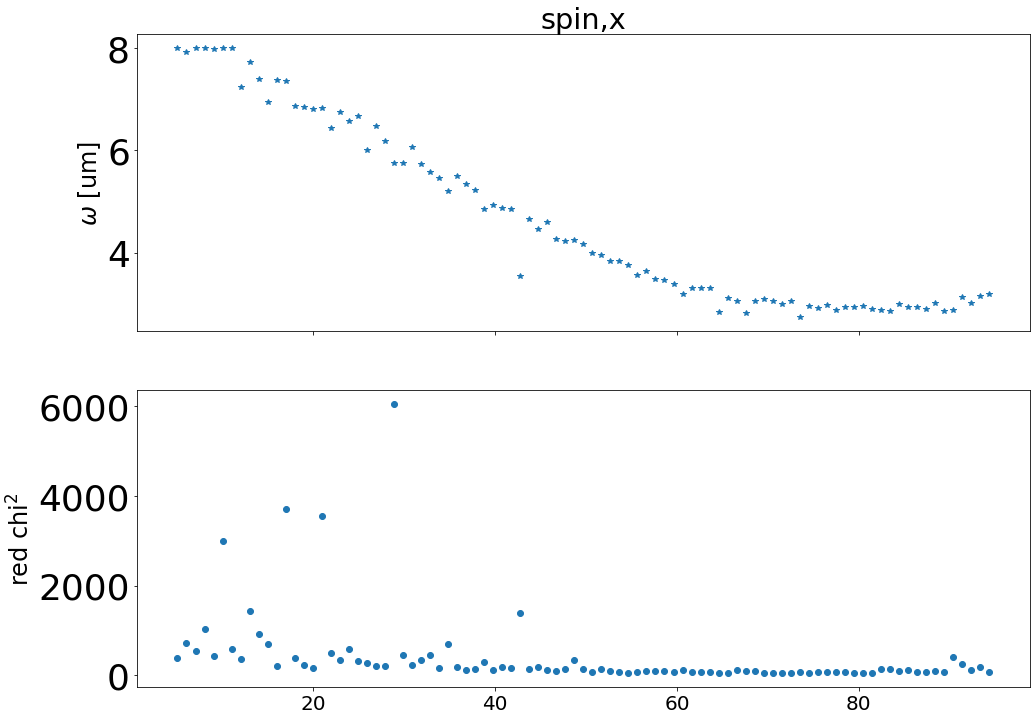

In [24]:
#x=np.arange(0,len(files_x),1)
x = make_x_axis_for_beam_profile(df_x)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("spin,x")
ax1.errorbar(x, x_width_spin,x_width_spin_err,linestyle="",marker="*")
ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, x_chi2_spin)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [25]:
y_width_spin,y_width_spin_err,y_mean_spin,y_chi2_spin,x_fits_spin = fit_dP_dX(df_y,axis="Y",detector="SPIN",avg_rng=10,plot=False)


100%|██████████| 91/91 [00:07<00:00, 14.11it/s]


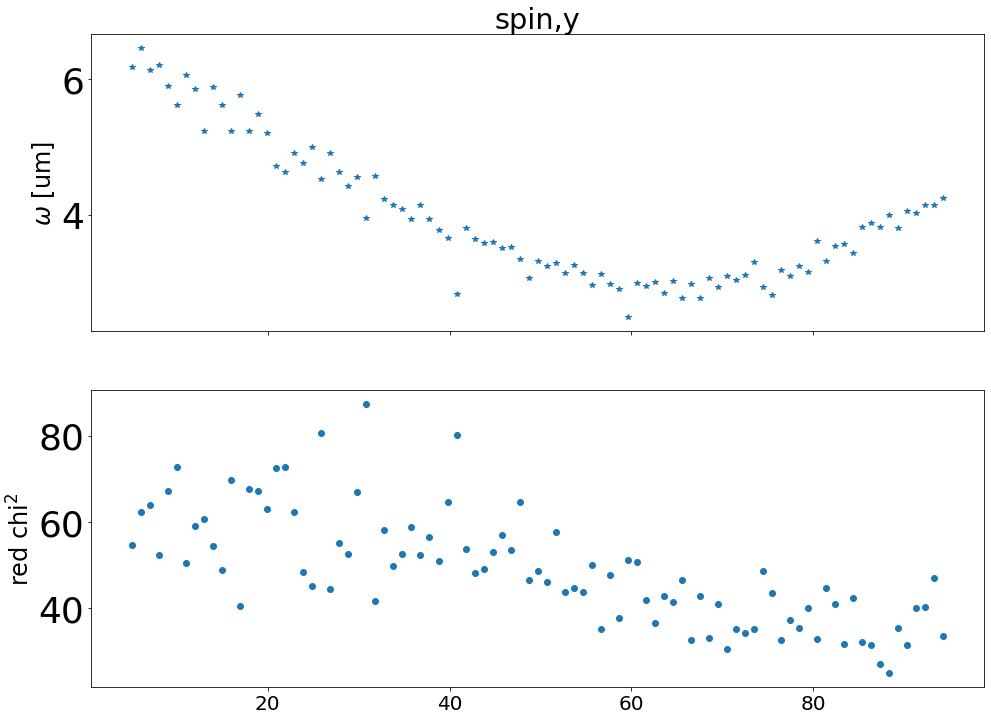

In [26]:
x = make_x_axis_for_beam_profile(df_y)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("spin,y")
ax1.errorbar(x, y_width_spin,y_width_spin_err,linestyle="",marker="*")
ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, y_chi2_spin)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [27]:
data_list = [x_width_spin,y_width_spin]
error_list = [x_width_spin_err,y_width_spin_err]
name_list = ["spin,x","spin,y"]
omega_list = []
focus_list = []

def beam_width(x,params=list):
    return params[0]*np.sqrt(1+((x-params[1])/np.pi/params[0]/params[0]*1.064)**2)
i=0
for data in data_list:
    i+=1
    def chisquare_beam_width(z,w):
        return chisquare_1d(function=beam_width,functionparams=[w,z],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

    data_x = np.asarray(make_x_axis_for_beam_profile(df_x))#np.arange(0,len(data),1)
    data_y = data
    data_y_error = error_list[i-1]

    #least_squares = LeastSquares(data_x, data_y, data_y_error, beam_width)
    m = Minuit(chisquare_beam_width, z=50, w=5,pedantic=False)  # we need starting values for a and b
    
    m.migrad(ncall=50000) # finds minimum of least_squares function
    print("The fit parameters for %s are determined as:" %name_list[i-1])
    for p in m.parameters:
        print("{} = {:.3f} +/- {:.3f}".format(p, m.values[p], m.errors[p]))
    print("The reduced chi2 is at: %d"  %(m.fval/(len(data)-2)))
    
    omega_list.append(m.values["w"])
    focus_list.append(m.values["z"])

The fit parameters for spin,x are determined as:
z = 58.562 +/- 0.009
w = 7.698 +/- 0.000
The reduced chi2 is at: 1493207
The fit parameters for spin,y are determined as:
z = 60.710 +/- 0.010
w = 3.029 +/- 0.001
The reduced chi2 is at: 3573


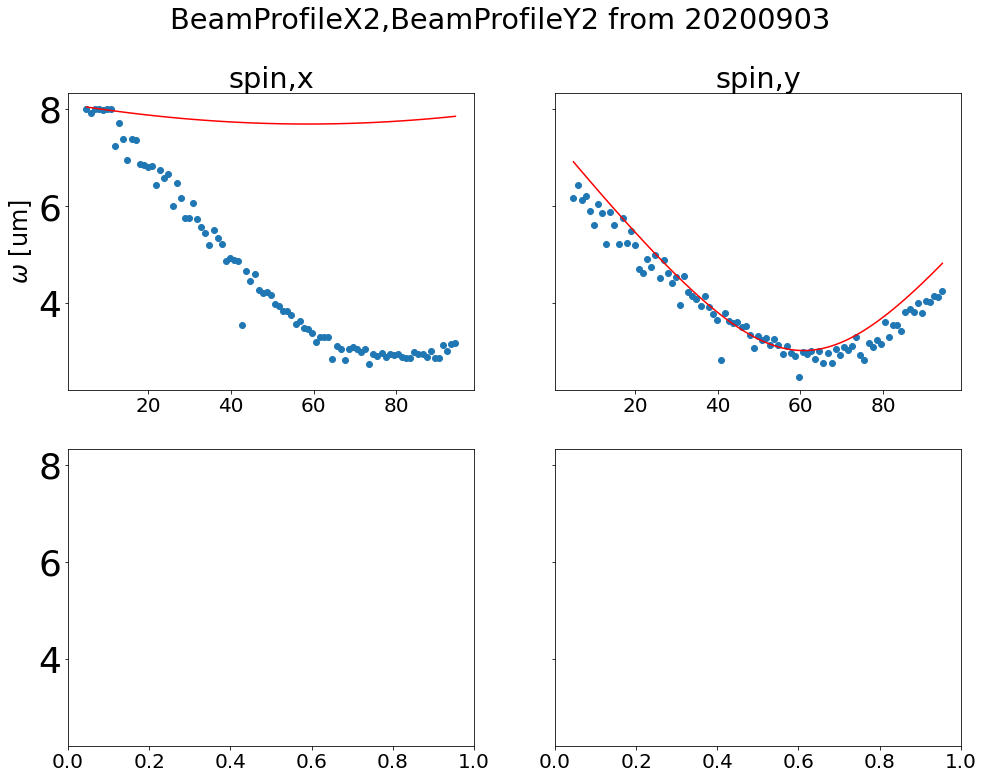

In [28]:
date=  Year + Month + Day  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharey=True)
fig.suptitle("%s,%s from %s" %(fname_x,fname_y,date))

x = np.asarray(make_x_axis_for_beam_profile(df_x))
ax1.set_title("spin,x")
ax1.scatter(x, x_width_spin)
ax1.plot(x, beam_width(x,[omega_list[0],focus_list[0]]),color="red")
ax1.set_ylabel("$\omega$ [um]")

ax2.set_title("spin,y")
ax2.scatter(x, y_width_spin)
ax2.plot(x, beam_width(x,[omega_list[1],focus_list[1]]),color="red")




plt.show()